# Part 2: Feature Engineering, Modeling, & Evaluation

## Imports

In [ ]:
# Standard Imports
import sys
import warnings
import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
import tensorflow            as tf

# Visuals
from warnings        import filterwarnings
from IPython.display import display, HTML
from IPython.display import display_html

# Modeling & Preprocessing
from xgboost                 import XGBRegressor
from sklearn.linear_model    import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.ensemble        import RandomForestRegressor
from sklearn.pipeline        import Pipeline

In [ ]:
# Colab Specific

# Data Reading
from google.colab import drive
drive.mount("/content/drive/")

# Custom Modules
sys.path.append('/content/drive/MyDrive/Data Sets/')
import graphs
import metrics
import stat_functions as sf

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Notebook settings
warnings.filterwarnings("ignore")

display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

In [ ]:
# Colab GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Colab GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Oct 16 01:26:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   63C    P0             19W /   72W |     189MiB /  23034MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Table Of Contents


- [Reading In The Data](#Reading-In-The-Data)
    - [Overview](#Overview)
    
    
    
- [Feature Engineering](#Feature-Engineering)
    - [Creating Segmental Features](#Creating-Segmental-Features)
        
    
    
- [Modeling](#Modeling)
    - [Functions](#Functions)
    - [Linear Regression](#Linear-Regression)
    - [Ridge](#Ridge)
    - [LASSO](#LASSO)
    - [ElasticNetCV](#ElasticNetCV)
    - [Random Forest Reression](#Random-Forest-Regression)
    - [XGBoosting](#XGBoosting)
    - [Prediction Dataframes](#Prediction-Dataframes)
     
     
    
- [Model Evaluation](#Model-Evaluation)
    - [Functions](#Evaluation-Functions)
    - [Plotting Predictions](#Plotting-Predictions)
    - [Plotting Residuals](#Plotting-Residuals)
    - [Final Model Selection](#Final-Model-Selection)

## Reading In The Data

In [ ]:
mri = pd.read_csv("/content/drive/MyDrive/Data Sets/mri_cleaned.csv")

### Overview

In [ ]:
mri.head()

,sex,age,hypertension,hyperlipidemia,diabetes,lvedv,lvesv,lv_wall_thickness,lvef,aortic_stenosis,...,mis_ischemia,mi_ischemia,mil_ischemia,mal_ischemia,aa_ischemia,as_ischemia,ai_ischemia,al_ischemia,smoker_status_former,smoker_status_never
0,1,37,0,0,0,613,501,0,18,0,...,0,0,0,0,0,0,0,0,0,1
1,1,74,0,1,0,569,492,1,14,0,...,0,0,0,0,0,1,0,1,0,1
2,1,78,1,1,1,564,500,0,11,0,...,1,1,0,0,1,1,0,0,0,1
3,1,61,0,1,0,531,435,1,18,0,...,0,0,0,0,0,0,0,0,0,1
4,1,53,0,0,0,522,408,0,21,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Checking the shape of the data
print(f"The shape of the dataset is: {mri.shape}")

The shape of the dataset is: (6417, 48)


In [ ]:
# Summary of column data types
mri.dtypes.value_counts()

,count
int64,48


## Feature Engineering

### Creating Segmental Features

Because the model attempts to predict the end diastolic volume, we want it to be as accurate as it can be.  As part of that, we will try to use different combinations of features in an attempt to achieve high accuracy.

The data have 34 columns that we wish to engineer: a column measuring scarification and a column measuring ischemia.  Because there are so many of them, we felt the need to experiment with how they are passed into the model.  We are unable to create multiplication interaction columns, because there are zeros.  Instead, we elected to create segmental columns by summing similar columns together: we will compare the model's performance with the originals and with the segmental columns.

We used this image to guide our create of segmental columns:

<img src = "../Images/cardiac-segmentation-for-cardiac-perfusion-defects.jpg" alt = "Cardiac Segmentation" height = "750" width = "750">

Case courtesy of Dr Hamid Chalian, <a href="https://radiopaedia.org/">Radiopaedia.org</a>. From the case <a href="https://radiopaedia.org/cases/47102">rID: 47102</a>

In [ ]:
# Creating columns based off of the red, blue, green, and yellow regions.
# We combined the apex and apical regions because there is only one region in the apex.

# New columns for scar tissue
mri["basal_he"]    = mri["ba_he"] + mri["bas_he"] + mri["bis_he"] \
                     + mri["bi_he"] + mri["bil_he"] + mri["bal_he"]
mri["mid_he"]      = mri["ma_he"] + mri["mas_he"] + mri["mis_he"] \
                     + mri["mi_he"] + mri["mil_he"] + mri["mal_he"]
mri["apical_he"]   = mri["aa_he"] + mri["as_he"] + mri["ai_he"] \
                     + mri["al_he"] + mri["apex_he"]

# New columns for ischemia
mri["basal_ischemia"]  = mri["ba_ischemia"] + mri["bas_ischemia"] + mri["bis_ischemia"] \
                         + mri["bi_ischemia"] + mri["bil_ischemia"] + mri["bal_ischemia"]
mri["mid_ischemia"]    = mri["ma_ischemia"] + mri["mas_ischemia"] + mri["mis_ischemia"] \
                         + mri["mi_ischemia"] + mri["mil_ischemia"] + mri["mal_ischemia"]
mri["apical_ischemia"] = mri["aa_ischemia"] + mri["as_ischemia"] + mri["ai_ischemia"] \
                         + mri["al_ischemia"]

# Checking that the number of columns has increased
print(f"The the data set has {mri.shape[1]} columns.")

The the data set has 54 columns.


We intended to create new columns based off the secondary axis (antero-septal, infero-septal, etc.) but because of how the apical region is divided we would have counted the apical regions more than once.

[Top](#Table-Of-Contents)

One of our goals was to see what would happen if we used the engineered features to reduce the overall number of features being passed into the model.  To accomplish that, we created two dataframes: one with the original set of features (48 including the target) and a second one with the engineered features (21 including the target).


From this point on, `_org` will be used to refer to the original set of features and `_eng` will be use to refer to the engineered features.  The default will be `_org`, so after train-splitting the original will just be `X_train` or `X_train_ss`.

In [ ]:
# Defining the original dataframe
mri_org = mri.drop(labels = ["basal_he", "mid_he",
                             "apical_he", "basal_ischemia",
                             "mid_ischemia", "apical_ischemia"],
                   axis = 1)

# Defining the dataframe with only new features
mri_eng = mri.drop(labels = ["lvesv", "ba_he", "bas_he", "bis_he", "bi_he",
                             "bil_he", "bal_he", "ma_he", "mas_he", "mis_he",
                             "mi_he", "mil_he", "mal_he", "aa_he", "as_he",
                             "ai_he", "al_he", "apex_he", "ba_ischemia",
                             "bas_ischemia", "bis_ischemia", "bi_ischemia",
                             "bil_ischemia", "bal_ischemia", "ma_ischemia",
                             "mas_ischemia", "mis_ischemia", "mi_ischemia",
                             "mil_ischemia", "mal_ischemia", "aa_ischemia",
                             "as_ischemia", "ai_ischemia", "al_ischemia"],
                   axis = 1)

# Checking to make sure the two have different numbers of columns
print(f"The dataframe with original features has {mri_org.shape[1]} columns.")
print(f"The dataframe with engineered features has {mri_eng.shape[1]} columns.")

The dataframe with original features has 48 columns.
The dataframe with engineered features has 20 columns.


[Top](#Table-Of-Contents)

## Modeling

Before we can start modeling, we have to perform a train-test split.  A train-test split allows us to train our data on one subset of the dataframe and train on another subset.

Since I have two versions of the dataframe, I will have to train-test split on both.

In [ ]:
# Setting up the X and y variables for the original features

# We're also dropping lvesv as it's strongly correlated to our target (lvedv)
# It had a correlation of 0.92 in the heatmap
X = mri_org.drop(["lvedv","lvesv"], axis = 1)
y = mri_org["lvedv"]

# Setting up the X and y variables for the engineered features
X_eng = mri_eng.drop("lvedv", axis = 1)
y_eng = mri_eng["lvedv"]

In [ ]:
# Train-test splitting mri_og
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    test_size    = 0.25)

# Train-test splitting mri_new
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_eng,
                                                                    y_eng,
                                                                    random_state = 42,
                                                                    test_size    = 0.25)

Each model going forward will be fit and evaluated on both sets of train-test splits.

Since we will be running models that need to have the data scaled, we will run both sets of X variables through `StandardScaler` and save them as new variables.

In [ ]:
# Instantiating the standard scaler
ss = StandardScaler()

In [ ]:
# Transforming the set with original features.

# Fit-transforming the X_train features
X_train_ss = ss.fit_transform(X_train)

# Transforming my X_test variables
X_test_ss  = ss.transform(X_test)

In [ ]:
# Transforming the sub-set with the features we engineered

# Fit-transforming the engineered X_train
X_train_eng_ss = ss.fit_transform(X_train_eng)

# Transforming the engineered X_test features
X_test_eng_ss  = ss.transform(X_test_eng)

### Functions

The `regression_summary` function has four metrics:

* Root mean squared error (RMSE) to measure the difference between the predicted values and the actual values;


* Mean absolute error (MAE) to measure the absolute mean error (this method is more robust to outliers);


* R<sup>2</sup> to measure variance in `y` caused by the `X` variables;


The `regression_summary_adjr2` function has four metrics:

* Root mean squared error (RMSE) to measure the difference between the predicted values and the actual values;


* Mean absolute error (MAE) to measure the absolute mean error (this method is more robust to outliers);


* R<sup>2</sup> to measure variance in `y` caused by the `X` variables;


* Adjusted R<sup>2</sup> to measure the same, but weighted for the number of features.

In [ ]:
# This allows us to display the dataframes of the linear regression
# coefficients side-by-side to save space.
def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw = True)

The code is from user `ntg` on StackOverflow.  [Here](https://stackoverflow.com/a/44923103) is the source.

[Top](#Table-Of-Contents)

### Linear Regression

When developing about our approach to modeling, we decided to start with the simplest model we could think of: the linear regression.

#### Original Set

The original set is the dataframe with its original 48 columns.

In [ ]:
# Instantiating the linear regression
lr = LinearRegression()

In [ ]:
# Fitting the linear regression to the original (non-engineered) subset
lr.fit(X_train_ss, y_train);

In [ ]:
# Generating predictions from the training set
train_preds = lr.predict(X_train_ss)

# Generating predictions from the test set
lr_preds = lr.predict(X_test_ss)

In [ ]:
metrics.regression_summary_adjr2(X_train_ss, y_train, train_preds)

,Scores
RMSE,43.041088
MAE,31.555164
R2,0.490282
Adj. R2,0.485361


In [ ]:
metrics.regression_summary_adjr2(X_test_ss, y_test, lr_preds)

,Scores
RMSE,44.154686
MAE,32.462544
R2,0.513158
Adj. R2,0.498784


Compared to the original version of this project which included lvesv, our metrics are half of what they were but they do not appear to be overfit which is good.

While a linear regression is not always the best model, one of its major selling points is that coefficients can be derived from the models.

The math for the linear regression is fairly simple: y = $\beta$<sub>0</sub> + $\beta$<sub>1</sub>X<sub>1</sub> + $\beta$<sub>1</sub>X<sub>1</sub>...$\beta$<sub>i</sub>X<sub>i</sub>.

From the formula we can see that the coefficient ($\beta$) scales the variables (X): the coefficients emphasize or reduce the impact of a given feature and thus we can derive relative importance from the coefficients.

In [ ]:
# Creating a dataframe makes looking the coefficients easier
lr_org = pd.DataFrame(data    = lr.coef_,
                      index   = X_test.columns,
                      columns = ["LR_Org"])

# Sorting for the head and tail five coefficients
head = lr_org.sort_values(by = "LR_Org", ascending = False).head()
tail = lr_org.sort_values(by = "LR_Org", ascending = False).tail()

display_side_by_side(head, tail)

,LR_Org
sex,26.928556
mitral_reg,11.640170
mal_ischemia,7.753097
ma_ischemia,7.303013
as_ischemia,7.266526
,LR_Org
hyperlipidemia,-3.059874
ai_ischemia,-4.320731
mil_ischemia,-5.919735
aa_ischemia,-8.560509


Displaying the heads and tails displays showed us the strongest and weakest coefficients as determined during the modeling process.

We found it interesting that `sex` is the strongest coefficient, we're not sure why it would be so important.

#### Engineered Subset

The engineered subset is the dataframe but with the features we engineered instead of the original 34 segmental features.

In [ ]:
# Instantiating the linear model
lr_2 = LinearRegression()

In [ ]:
# Fitting the linear regression to the subset with the features we engineered

lr_2.fit(X_train_eng_ss, y_train_eng);

In [ ]:
# Generating predictions for the training set
train_preds = lr_2.predict(X_train_eng_ss)

# Generating my predictions for the testing set
lr_2_preds  = lr_2.predict(X_test_eng_ss)

In [ ]:
metrics.regression_summary_adjr2(X_train_eng_ss, y_train_eng, train_preds)

,Scores
RMSE,43.236153
MAE,31.648942
R2,0.485651
Adj. R2,0.483612


In [ ]:
metrics.regression_summary_adjr2(X_test_eng_ss, y_test_eng, lr_2_preds)

,Scores
RMSE,44.134498
MAE,32.488835
R2,0.513603
Adj. R2,0.507773


As we saw above, these results are half of what they were when we included lvesv in the data, but there is no sign of over fitting based on the evaluation.

In [ ]:
# It is easier to view the coefficients in a df
lr_eng = pd.DataFrame(data    = lr_2.coef_,
                      index   = X_test_eng.columns,
                      columns = ["LR_Eng"])

# Masking the head and tail five
head = lr_eng.sort_values(by = "LR_Eng", ascending = False).head(5)
tail = lr_eng.sort_values(by = "LR_Eng", ascending = False).tail(5)

display_side_by_side(head,tail)

,LR_Eng
sex,26.923537
mitral_reg,11.906456
hypertension,5.723743
smoker_status_never,4.921353
smoker_status_former,2.022807
,LR_Eng
aortic_reg,-1.393885
apical_ischemia,-1.652473
tricusp_reg,-1.757306
lvef,-2.174428


Interesting again to see that `sex` has is the strongest coefficient.

[Top](#Table-Of-Contents)

### Ridge

Ridge regression works by imposing a penalty on the coefficients: it uses the $\ell$<sub>2</sub> regularization which shrinks them towards 0 and effectively removes features without actually doing so and reduces the overall complexity.


Because the features can be so strongly affected by the regularization it is important to have them all be on the same scale; this was done earlier with `StandardScaler`.

#### Original Set

In [ ]:
# Instantiating the ridge model
ridge = RidgeCV()

In [ ]:
# Fitting the ridge model to the training data
ridge.fit(X_train_ss, y_train);

In [ ]:
# Generating predictions for the training set
train_preds = ridge.predict(X_train_ss)

# Generating Predictions for the testing set
ridge_preds = ridge.predict(X_test_ss)

Because the RidgeCV and following models use scaled data, they lose the feature columns and instead use arrays of data.  For this reason, an adjusted R<sup>2</sup> cannot be used.

In [ ]:
metrics.regression_summary(y_train, train_preds)

,Score
RMSE,43.041180
MAE,31.548252
R2,0.490279


In [ ]:
metrics.regression_summary(y_test, ridge_preds)

,Score
RMSE,44.158760
MAE,32.456841
R2,0.513068


This Ridge model's performance is very similar to the linear model's performance which was surprising to us because we had expected the regularization to improve its performance.

#### Engineered Subset

In [ ]:
# Instantiating the ridge model
ridge_2 = RidgeCV()

In [ ]:
# Fitting the ridge model to the data with engineered features.
ridge_2.fit(X_train_eng_ss, y_train_eng);

In [ ]:
# Generating predictions for the training data
train_preds = ridge_2.predict(X_train_eng_ss)

# Generating predictions for the test data
ridge_2_preds = ridge_2.predict(X_test_eng_ss)

In [ ]:
metrics.regression_summary(y_train_eng, train_preds)

,Score
RMSE,43.236238
MAE,31.642307
R2,0.485649


In [ ]:
metrics.regression_summary(y_test_eng, ridge_2_preds)

,Score
RMSE,44.139271
MAE,32.484038
R2,0.513498


Again, we were expected a regularized model to improve performance compared to a non-regularized one.

[Top](#Table-Of-Contents)

### LASSO

LASSO (Least Absolute Shrinkage and Selection Operator) is conceptually similar to Ridge in that it penalizes coefficients, but it uses $\ell$<sub>2</sub> regularization which actually reduces the coefficients of unimportant features to exactly 0.

LASSO also needs to have the features on the same scale.

#### Original Set

In [ ]:
# Instantiating the LASSO model
lasso = LassoCV()

In [ ]:
# Fitting the lasso to my training data without engineered features
lasso.fit(X_train_ss, y_train);

In [ ]:
# Generating predictions for the training data
train_preds = lasso.predict(X_train_ss)

# Generating predictions for the testing data
lasso_preds = lasso.predict(X_test_ss)

In [ ]:
metrics.regression_summary(y_train, train_preds)

,Score
RMSE,43.255615
MAE,31.601826
R2,0.485188


In [ ]:
metrics.regression_summary(y_test, lasso_preds)

,Score
RMSE,44.300960
MAE,32.496059
R2,0.509927


Same story as with the Ridge models: we were expecting regularization to improve performance but there's no appreciable difference.

#### Engineered Subset

In [ ]:
# Instantiating the lasso model
lasso_2 = LassoCV()

In [ ]:
# Fitting the lasso to my training data with engineered features
lasso_2.fit(X_train_eng_ss, y_train_eng);

In [ ]:
# Generating predictions for the training data
train_preds = lasso_2.predict(X_train_eng_ss)

# Generating predictions for the testing data
lasso_2_preds = lasso_2.predict(X_test_eng_ss)

In [ ]:
metrics.regression_summary(y_train_eng, train_preds)

,Score
RMSE,43.277961
MAE,31.664866
R2,0.484656


In [ ]:
metrics.regression_summary(y_test_eng, lasso_2_preds)

,Score
RMSE,44.229923
MAE,32.499778
R2,0.511498


Same story as with the Ridge models and the other LASSO model: we were expecting regularization to improve performance but there's no appreciable difference.

[Top](#Table-Of-Contents)

### ElasticNetCV

An ElasticNet is similar to both Ridge _and_ LASSO models: it is a compromise between the $\ell$<sub>1</sub> and $\ell$<sub>2</sub> regularization methods.  In practice the model drives down non-significant features but does not remove them entirely.

Like the Ridge and LASSO models, an ElasticNet needs to have the data be on the same scale.

#### Original Set

In [ ]:
# Instantiating the model
enet = ElasticNetCV()

In [ ]:
# Fitting the model to the original data set
enet.fit(X_train_ss, y_train);

In [ ]:
# Generating training predictions
train_preds = enet.predict(X_train_ss)

# Generating testing predictions
enet_preds  = enet.predict(X_test_ss)

In [ ]:
metrics.regression_summary(y_train, train_preds)

,Score
RMSE,43.090073
MAE,31.436451
R2,0.489121


In [ ]:
metrics.regression_summary(y_test, enet_preds)

,Score
RMSE,44.299864
MAE,32.401931
R2,0.509952


#### Engineered Subset

In [ ]:
# Instantiatig the model
enet_2 = ElasticNetCV()

In [ ]:
# Fitting the model to the data with engineered features
enet_2.fit(X_train_eng_ss, y_train_eng);

In [ ]:
# Generating training predictions
train_preds = enet_2.predict(X_train_eng_ss)

# Generating testing predictions
enet_2_preds = enet_2.predict(X_test_eng_ss)

In [ ]:
metrics.regression_summary(y_train_eng, train_preds)

,Score
RMSE,43.264361
MAE,31.557870
R2,0.484980


In [ ]:
metrics.regression_summary(y_test_eng, enet_2_preds)

,Score
RMSE,44.251739
MAE,32.428288
R2,0.511016


Again we're surprised that not only did the regularized models not produce an increase in performance compared to the non-regulaizred linear model, but that the engineered features did not reduce performance compared to the original which we observe in the original version of our modeling.

[Top](#Table-Of-Contents)

### Random Forest Regression

A random forest regressor is a regression method based on decision trees.  A decision tree splits the data into branches and evaluates the quality of a split by using a metric (in our case MSE).  Random forests implement bagging (bootstrap aggregation) mean that they take random samples of rows with replacement.  However, another level of randomness by randomly sampling a given number of features.  When it comes to predicting, it generates the mean of each node.  We chose to run a random forest regression because, while the linear regression did fairly well, we wanted to optimize our metrics given the nature of the data we have.

In addition to running the model, we chose to use a pipeline to make it easier for us to find optimal hyperparameter values; hyperparameters are parameters defined by the individual running the code.

#### Original Set

One of the important things we can extract from a random forest model is the feature importance which is a simple measure of how important each feature is in the model similar to a linear model's coefficients.  However when we run the random forest in a grid search we lose the ability to extract them because the model is a gridsearch object.  To get around that we ran a gridsearch to find the best features and then ran a random forest with those values.

In [ ]:
"""# Instantiating the pipeline

rfr_pipe = Pipeline([("rfr", RandomForestRegressor(random_state = 42))])

# Setting the values for the gridsearch

# These are the optimized values

params = {"rfr__n_estimators"     : [429],
          "rfr__max_depth"        : [None],
          "rfr__min_samples_split": [30],
          "rfr__min_samples_leaf" : [2]}

# Instantiating the gridsearch

rfr_gs = GridSearchCV(rfr_pipe,
                      param_grid = params,
                      cv         = 5)

# Fitting the gridsearch to the training data

rfr_gs.fit(X_train_ss, y_train);

# Getting the best parameters

rfr_gs.best_params_""";


In [ ]:
# Instantiating the random forest
rfr = RandomForestRegressor(random_state      = 42,
                            n_estimators      = 429,
                            max_depth         = None,
                            min_samples_split = 30,
                            min_samples_leaf  = 2,
                            n_jobs            = 6)

# Fitting the random forest
rfr.fit(X_train_ss, y_train);

In [ ]:
# Generating training predictions
train_preds = rfr.predict(X_train_ss)

# Generating testing predictions
rfr_preds = rfr.predict(X_test_ss)

In [ ]:
metrics.regression_summary_adjr2(X_train_ss, y_train, train_preds)

,Scores
RMSE,33.251860
MAE,24.258083
R2,0.695774
Adj. R2,0.692837


In [ ]:
metrics.regression_summary_adjr2(X_test_ss, y_test, rfr_preds)

,Scores
RMSE,41.893623
MAE,31.011907
R2,0.561742
Adj. R2,0.548802


Based on previous experience, we were expecting the tree based methods to improve performance compared to linear methods which we can see here. However, we are seeing a significant amount of overfitting whne compared training and test evaluations. This is likely due to the `n_estimators` hyperparameter being so high.

In [ ]:
# Creating dataframes of the feature importances
rfr_org = pd.DataFrame(data    = rfr.feature_importances_,
                       index   = X_test.columns,
                       columns = ["RFR_Org"])

# Sorting for the head and tail five coefficients
head = rfr_org.sort_values(by = "RFR_Org", ascending = False).head()
tail = rfr_org.sort_values(by = "RFR_Org", ascending = False).tail()

display_side_by_side(head,tail)

,RFR_Org
lvef,0.628004
age,0.106117
sex,0.089774
mitral_reg,0.055062
aortic_reg,0.022194
,RFR_Org
mil_ischemia,0.000665
aa_ischemia,0.000646
bas_ischemia,0.000617
ba_ischemia,0.000549


We're not surprised that the systolic volume has such a high weight, but we were surprised by the difference between the weights of the strongest five importances.

#### Engineered Subset

We are doing the same here as with the random forest with the original features.

In [ ]:
"""
# Setting the values for the gridsearch

rfr_pipe = Pipeline([("rfr", RandomForestRegressor(random_state = 42))])

# These are the optimized values

params = {"rfr__n_estimators"     : [283],
          "rfr__max_depth"        : [None],
          "rfr__min_samples_split": [31],
          "rfr__min_samples_leaf" : [2]}

# Instantiating the gridsearch

rfr_2_gs = GridSearchCV(rfr_pipe,
                        param_grid = params,
                        cv         = 5)

# Fitting the gridsearch to the training data

rfr_2_gs.fit(X_train_eng_ss, y_train_eng);

# Getting the best parameters

rfr_2_gs.best_params_
""";

In [ ]:
# Instantiating the random forest
rfr_2 = RandomForestRegressor(random_state      = 42,
                              n_estimators      = 283,
                              max_depth         = None,
                              min_samples_split = 31,
                              min_samples_leaf  = 2,
                              n_jobs            = 6)

# Fitting the random forest

rfr_2.fit(X_train_eng_ss, y_train_eng);

In [ ]:
# Generating training predictions
train_preds = rfr_2.predict(X_train_eng_ss)

# Generating testing predictions
rfr_2_preds = rfr_2.predict(X_test_eng_ss)

In [ ]:
metrics.regression_summary_adjr2(X_train_eng_ss, y_train_eng, train_preds)

,Scores
RMSE,33.934365
MAE,24.731847
R2,0.683158
Adj. R2,0.681901


In [ ]:
metrics.regression_summary_adjr2(X_test_eng_ss, y_test_eng, rfr_2_preds)

,Scores
RMSE,41.796815
MAE,30.981824
R2,0.563765
Adj. R2,0.558536


[add comment]

In [ ]:
# Creating dataframes of the feature importances
rfr_eng = pd.DataFrame(data    = rfr_2.feature_importances_,
                       index   = X_test_eng.columns,
                       columns = ["RFR_Eng"])

# Sorting for the head and tail five coefficients
head = rfr_eng.sort_values(by = "RFR_Eng", ascending = False).head()
tail = rfr_eng.sort_values(by = "RFR_Eng", ascending = False).tail()

display_side_by_side(head,tail)

,RFR_Eng
lvef,0.640532
age,0.108288
sex,0.092461
mitral_reg,0.057389
aortic_reg,0.022374
,RFR_Eng
smoker_status_never,0.003963
mid_ischemia,0.003808
apical_ischemia,0.003125
smoker_status_former,0.002641


Again we're interested in why `sex` keeps showing up as a top coefficient, `age` as well.

[Top](#Table-Of-Contents)

### XGBoosting

XGBoosting is a method that combines gradient descent with boosting.  The alogrithm works by generating a linear regression, deriving the coefficients, and then it runs further linear regressions until the sum of constants is constant.  Additionally, XGBoost makes use of _both_ $\ell$<sub>1</sub> _and_ $\ell$<sub>2</sub> regularization to help minimize overfitting on the training data.

#### Original Set

In [ ]:
"""# Setting the values for the gridsearch

# Instantiating the pipeline

xgbr_pipe = Pipeline([("xgbr", XGBRegressor(random_state = 42,
                                            objective    = "reg:squarederror",
                                            n_jobs       = 6))])

# These are the optimized values

params = {"xgbr__n_estimators" : [100],
          "xgbr__max_depth"    : [2],
          "xgbr__learning_rate": [0.1],
          "xgbr__gamma"        : [0]}

# Instantiating the gridsearch

xgbr_gs = GridSearchCV(xgbr_pipe,
                       param_grid = params,
                       cv         = 5)

# Fitting the gridsearch to the training data

xgbr_gs.fit(X_train_ss, y_train);

# Getting the best parameters

xgbr_gs.best_params_""";

In [ ]:
# Instantiating the xgboost regressor
xgb = XGBRegressor(random_state   = 42,
                   objective      = "reg:squarederror",
                   n_jobs         = 6,
                   n_estimators   = 100,
                   max_estimators = 6,
                   max_depth      = 2,
                   gamma          = 0,
                   learning_rate  = 0.1)

In [ ]:
# Fitting to my training data
xgb.fit(X_train_ss, y_train);

In [ ]:
# Generating training predictions
train_preds = xgb.predict(X_train_ss)

# Generating testing predictions
xgb_preds = xgb.predict(X_test_ss)

In [ ]:
metrics.regression_summary_adjr2(X_train_ss, y_train, train_preds)

,Scores
RMSE,38.349646
MAE,28.563416
R2,0.595343
Adj. R2,0.591437


In [ ]:
metrics.regression_summary_adjr2(X_test_ss, y_test, xgb_preds)

,Scores
RMSE,41.561065
MAE,30.952608
R2,0.568672
Adj. R2,0.555937


We were expecting that XGBoost would be the best performing model because of how the algorithm works, which so far it is. There's minor overitting likely due to the `n_estimators` being so high, but it's not significant enough to be a concern.

Similarly to the linear regression's coefficients, we are able to retrieve coefficients from the XGBoost and they work the same way: they weight the features while the model is predicting.

In [ ]:
# Creating a coefficients dataframe
xgb_org = pd.DataFrame(data    = xgb.feature_importances_,
                       index   = X_test.columns,
                       columns = ["XGB_Org"])

# Sorting for the head and tail five coefficients
head = xgb_org.sort_values(by = "XGB_Org", ascending = False).head()
tail = xgb_org.sort_values(by = "XGB_Org", ascending = False).tail()

display_side_by_side(head,tail)

,XGB_Org
lvef,0.392499
sex,0.142287
mitral_reg,0.091462
age,0.060761
as_ischemia,0.035380
,XGB_Org
mal_ischemia,0.0
mil_ischemia,0.0
ai_ischemia,0.0
al_ischemia,0.0


Again we're seeing `sex` and `age` appearing as top coefficients!

#### Engineered Subset

In [ ]:
""""# Setting the values for the gridsearch

# Instantiating the pipeline

xgbr_pipe = Pipeline([("xgbr", XGBRegressor(random_state = 42,
                                            objective    = "reg:squarederror",
                                            n_jobs       = 6))])

# These are the optimized values

params = {"xgbr__n_estimators"  : [437],
          "xgbr__max_depth"     : [4],
          "xgbr__learning_rate" : [0.015],
          "xgbr__gamma"         : [7]}

# Instantiating the gridsearch

xgbr_gs = GridSearchCV(xgbr_pipe,
                       param_grid = params,
                       cv         = 5)

# Fitting the gridsearch to the training data

xgbr_gs.fit(X_train_eng_ss, y_train_eng);

# Getting the best parameters

xgbr_gs.best_params_""";

In [ ]:
xgb_2 = XGBRegressor(random_state  = 42,
                     n_jobs        = 6,
                     objective     = "reg:squarederror",
                     n_estimators  = 437,
                     max_depth     = 4,
                     learning_rate = 0.015,
                     gamma         = 7)

In [ ]:
xgb_2.fit(X_train_eng_ss, y_train_eng);

In [ ]:
# Generating predictions for the training data
train_preds = xgb_2.predict(X_train_eng_ss)

# Generating predictions for the test data
xgb_2_preds = xgb_2.predict(X_test_eng_ss)

In [ ]:
metrics.regression_summary_adjr2(X_train_eng_ss, y_train_eng, train_preds)

,Scores
RMSE,35.404380
MAE,26.849487
R2,0.655112
Adj. R2,0.653745


In [ ]:
metrics.regression_summary_adjr2(X_test_eng, y_test_eng, xgb_2_preds)

,Scores
RMSE,41.904777
MAE,30.871096
R2,0.561508
Adj. R2,0.556252


There's no appreciable difference between XGB regressors which is what we saw in the original version of this project, but we are seeing an increase in overfitting which is concerning.

In [ ]:
# Creating a coefficients dataframe

xgb_eng = pd.DataFrame(data    = xgb_2.feature_importances_,
                       index   = X_test_eng.columns,
                       columns = ["XGB_Eng"])

#Sorting for the head and tail five coefficients

head = xgb_eng.sort_values(by = "XGB_Eng", ascending = False).head()
tail = xgb_eng.sort_values(by = "XGB_Eng", ascending = False).tail()

display_side_by_side(head,tail)

,XGB_Eng
lvef,0.381565
sex,0.149508
mitral_reg,0.082862
age,0.057809
aortic_reg,0.036883
,XGB_Eng
apical_he,0.018110
smoker_status_never,0.017615
diabetes,0.015167
lv_wall_thickness,0.014949


[Top](#Table-Of-Contents)

### Prediction Dataframes

In [ ]:
# Creating a dataframe out of the four sets of predictions
# The y_test is for comparison

# Original features

org_model_predictions = pd.DataFrame([np.array(y_test), lr_preds, ridge_preds,
                                      lasso_preds, enet_preds, rfr_preds, xgb_preds],
                                     index = ["Actual", "Linear_Reg.", "RidgeCV", "LassoCV",
                                              "ElasticNetCV", "Random Forest Reg.", "XGBoost Reg."]).T

# Engineeered features

eng_model_predictions = pd.DataFrame([np.array(y_test_eng), lr_2_preds, ridge_2_preds,
                                      lasso_2_preds, enet_2_preds, rfr_2_preds, xgb_2_preds],
                                     index = ["Actual", "Linear_Reg.", "RidgeCV", "LassoCV",
                                              "ElasticNetCV", "Random Forest Reg.", "XGBoost Reg."]).T

# Setting the index to the X_test index and sorting from lowest to highest

org_model_predictions_v2 = org_model_predictions.set_index(X_test.index).sort_index(ascending = True)
eng_model_predictions_v2 = eng_model_predictions.set_index(X_test.index).sort_index(ascending = True)

# Saving as a .csv file

org_model_predictions_v2.to_csv("/content/drive/MyDrive/Data Sets/original_model_predictions_v2.csv")
eng_model_predictions_v2.to_csv("/content/drive/MyDrive/Data Sets/engineered_model_predictions_v2.csv")

#### Reading In The Files

In [ ]:
original_features   = pd.read_csv("/content/drive/MyDrive/Data Sets/original_model_predictions_v2.csv", index_col = 0)
engineered_features = pd.read_csv("/content/drive/MyDrive/Data Sets/engineered_model_predictions_v2.csv", index_col = 0)

In [ ]:
# Checking that the df looks correct

original_features.head()

,Actual,Linear_Reg.,RidgeCV,LassoCV,ElasticNetCV,Random Forest Reg.,XGBoost Reg.
8,493.0,280.364151,280.104013,271.969484,274.487470,348.921534,375.986145
14,459.0,248.126473,247.864457,242.811116,241.046076,300.470458,277.454041
15,457.0,289.311128,288.936734,283.727387,281.138313,362.328677,373.895630
17,448.0,289.439928,289.118684,286.486164,282.549853,349.238362,367.335480
19,440.0,258.509315,258.308863,259.395820,254.291192,313.353735,314.210907


In [ ]:
# Checking that the df look correct

engineered_features.head()

,Actual,Linear_Reg.,RidgeCV,LassoCV,ElasticNetCV,Random Forest Reg.,XGBoost Reg.
8,493.0,282.537098,282.204901,274.376815,276.075331,348.115912,352.824036
14,459.0,243.210552,243.016119,244.208272,240.026688,299.709242,287.742615
15,457.0,289.853122,289.483489,286.155470,283.179322,363.755904,384.887115
17,448.0,290.156156,289.836171,288.379834,284.496378,349.071600,386.797913
19,440.0,257.757141,257.538262,258.127288,254.038549,318.336359,319.368073


[Top](#Table-Of-Contents)

## Model Evaluation

### Evaluation Functions

This function simply plots the predictions from all four models together with the true `y` values in one scatter plot.

In [ ]:
def plot_linear_predictions(df, true, title):

    # Setting the `facecolor` to white makes it easier to see on a different background.

    plt.figure(figsize   = (18,6))

    # Generating a scatter plot for each set of values, but they'll be on one chart.
    plt.scatter(x = true, y = "Actual", data = df,
                color = "black", label = "Actual")
    plt.scatter(x = true, y = "Linear_Reg.", data = df,
                color = "red", label = "Linear Reg.")
    plt.scatter(x = true, y = "RidgeCV", data = df,
                color = "blue", label = "RidgeCV")
    plt.scatter(x = true, y = "LassoCV", data = df,
                color = "green", label = "LassoCV")
    plt.scatter(x = true, y = "ElasticNetCV", data = df,
                color = "orange", label = "ElasticNetCV")

    # Setting graph parameters
    plt.title(f"Linear Predictions From The {title}", size = 18)
    plt.xlabel("Predicted", size = 16)
    plt.ylabel("Actual", size = 16)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.legend(bbox_to_anchor = (1.04,1), loc = "upper left");

In [ ]:
def plot_nonlinear_predictions(df, true, title):
    plt.figure(figsize   = (18,6),
               facecolor = "white")
    plt.scatter(x = true, y = "Actual", data = df, color = "black",
                label = "Actual")
    plt.scatter(x = true, y = "Random Forest Reg.", data = df,
                color = "red", label = "Random Forest Reg.")
    plt.scatter(x = true, y = "XGBoost Reg.", data = df,
                color = "green", label = "XGBoost Reg.")
    plt.title(f"Non-Linear Predictions From The {title}", size = 18)
    plt.xlabel("Predicted", size = 16)
    plt.ylabel("Actual", size = 16)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.legend(bbox_to_anchor = (1.04,1), loc = "upper left");

[Top](#Table-Of-Contents)

### Plotting Predictions

While we had a good idea of how the models were performing based on the scores calculated by our metrics, we felt that visualizing the predictions of the model would help us have a better idea of where the models were strong and weak.  To do that, we simply plotting the four sets of predictions along with the true values in  a scatter plot.

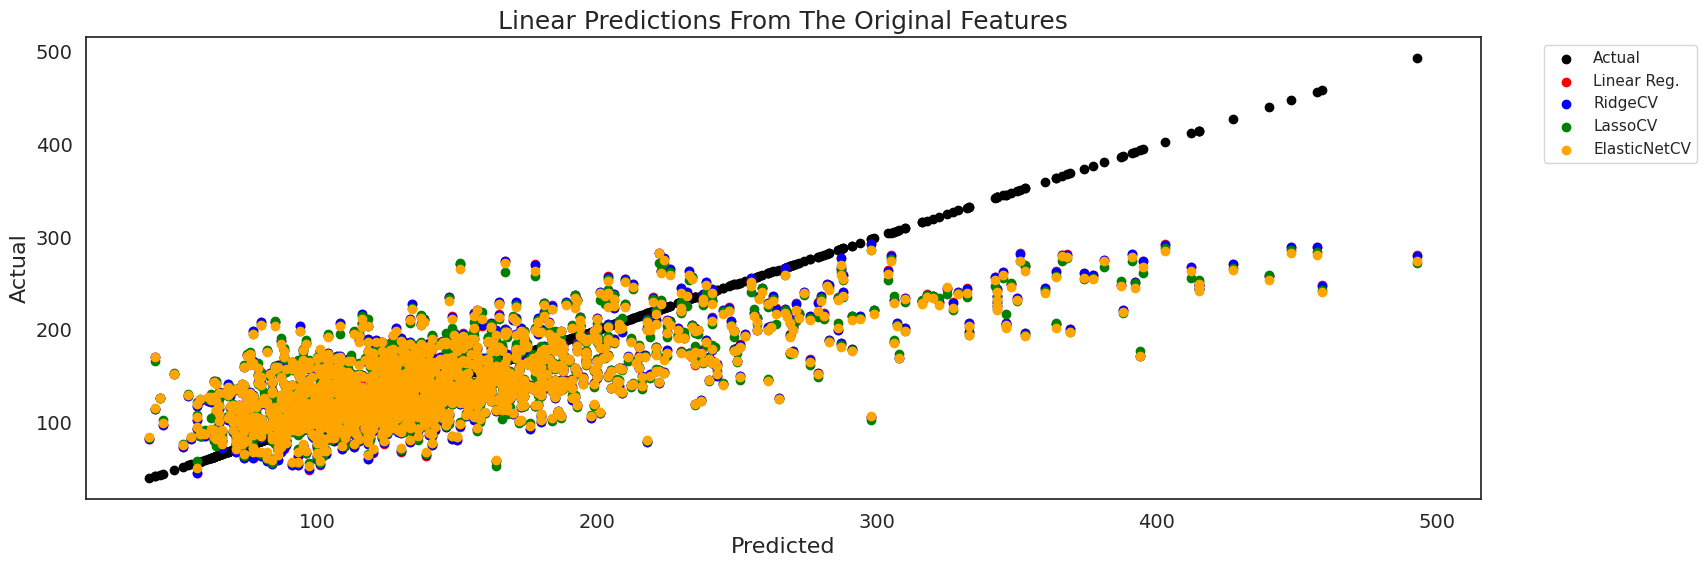

In [ ]:
plot_linear_predictions(df    = original_features,
                        true  = "Actual",
                        title = "Original Features")

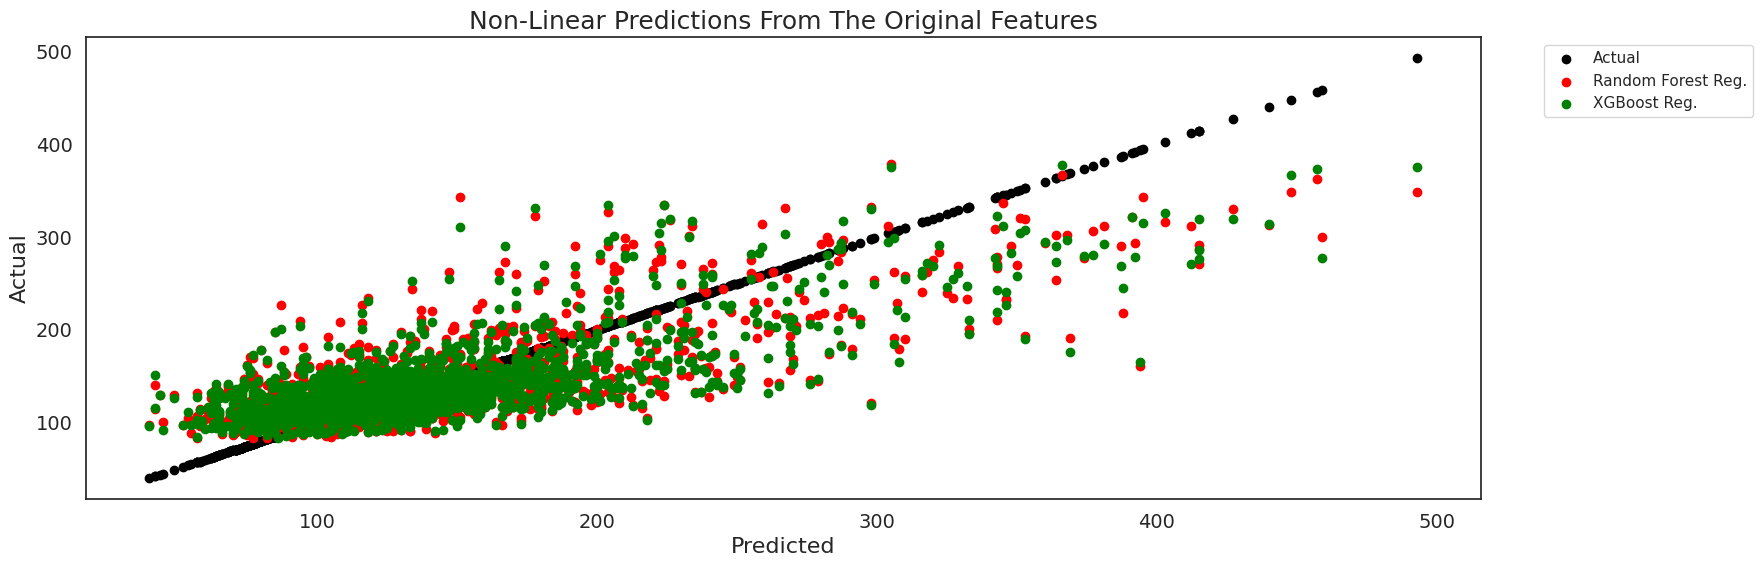

In [ ]:
plot_nonlinear_predictions(df    = original_features,
                           true  = "Actual",
                           title = "Original Features")

Unlike in the original version of this modeling, we're not seeing a prominent curve in the predictions made by the models: instead is just linear and diverge from the actual values: the data is strongly heteroskedastic.

The same is true of the non-linear predictions, except the non-linear predictions scatter much more significantly for higher predictions.

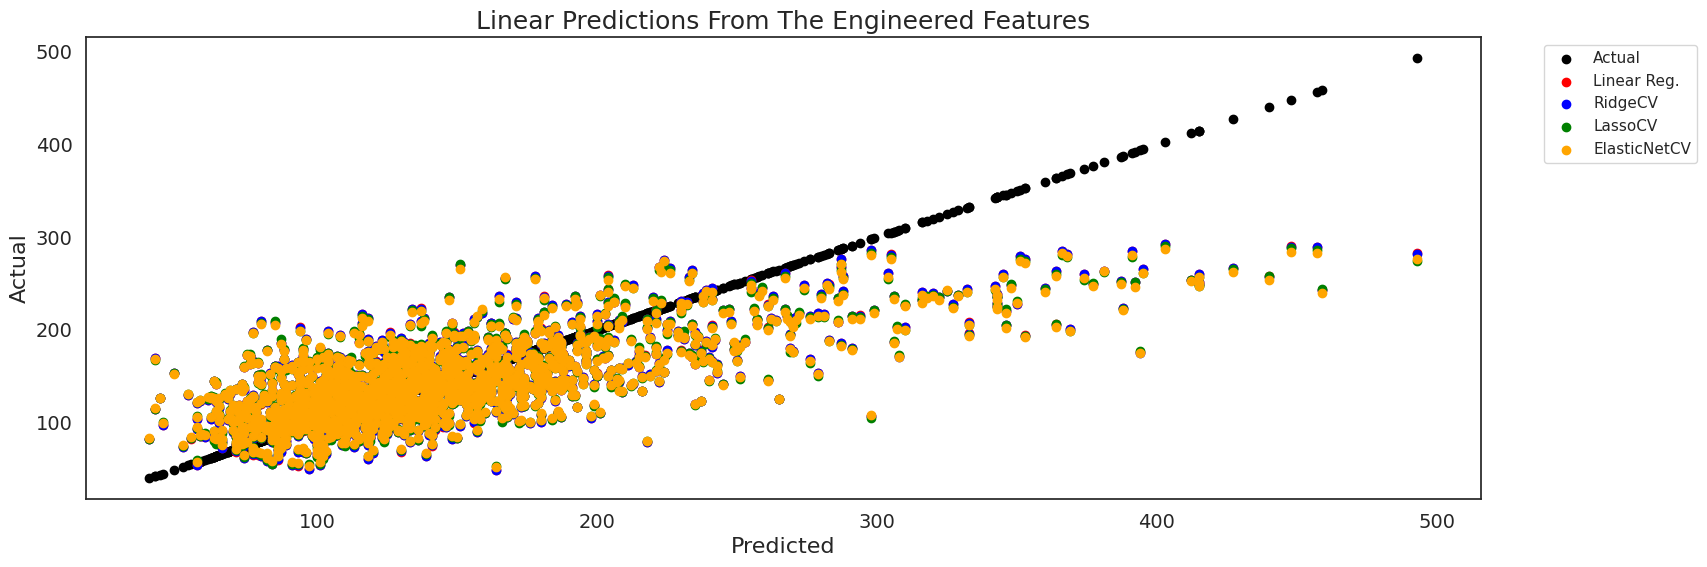

In [ ]:
plot_linear_predictions(df    = engineered_features,
                        true  = "Actual",
                        title = "Engineered Features")

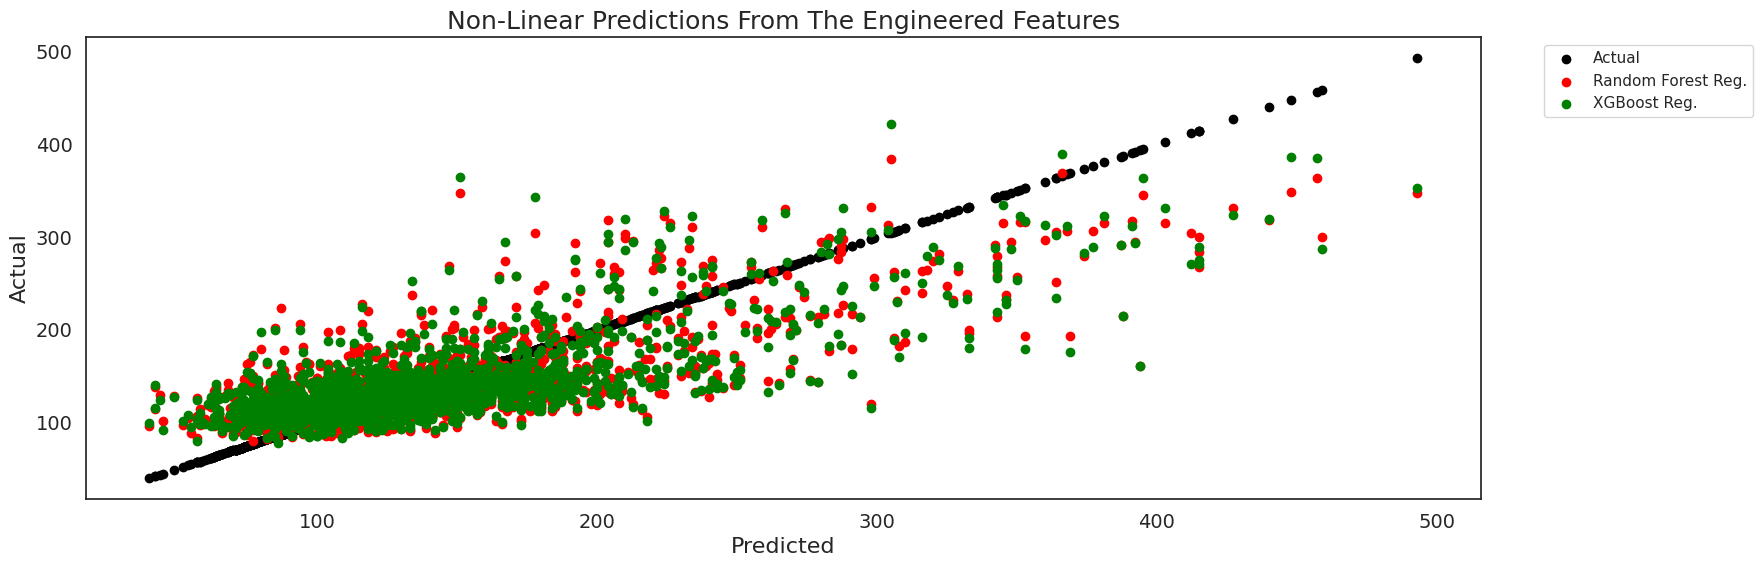

In [ ]:
plot_nonlinear_predictions(df    = engineered_features,
                           true  = "Actual",
                           title = "Engineered Features")

There's no appreciable diference in the sets of predictions.

[Top](#Table-Of-Contents)

### Plotting Residuals

The residuals are simply the difference between the actual values and the predicted values.  Looking at the residuals allows us to detect if the independence of errors assumption is violated.

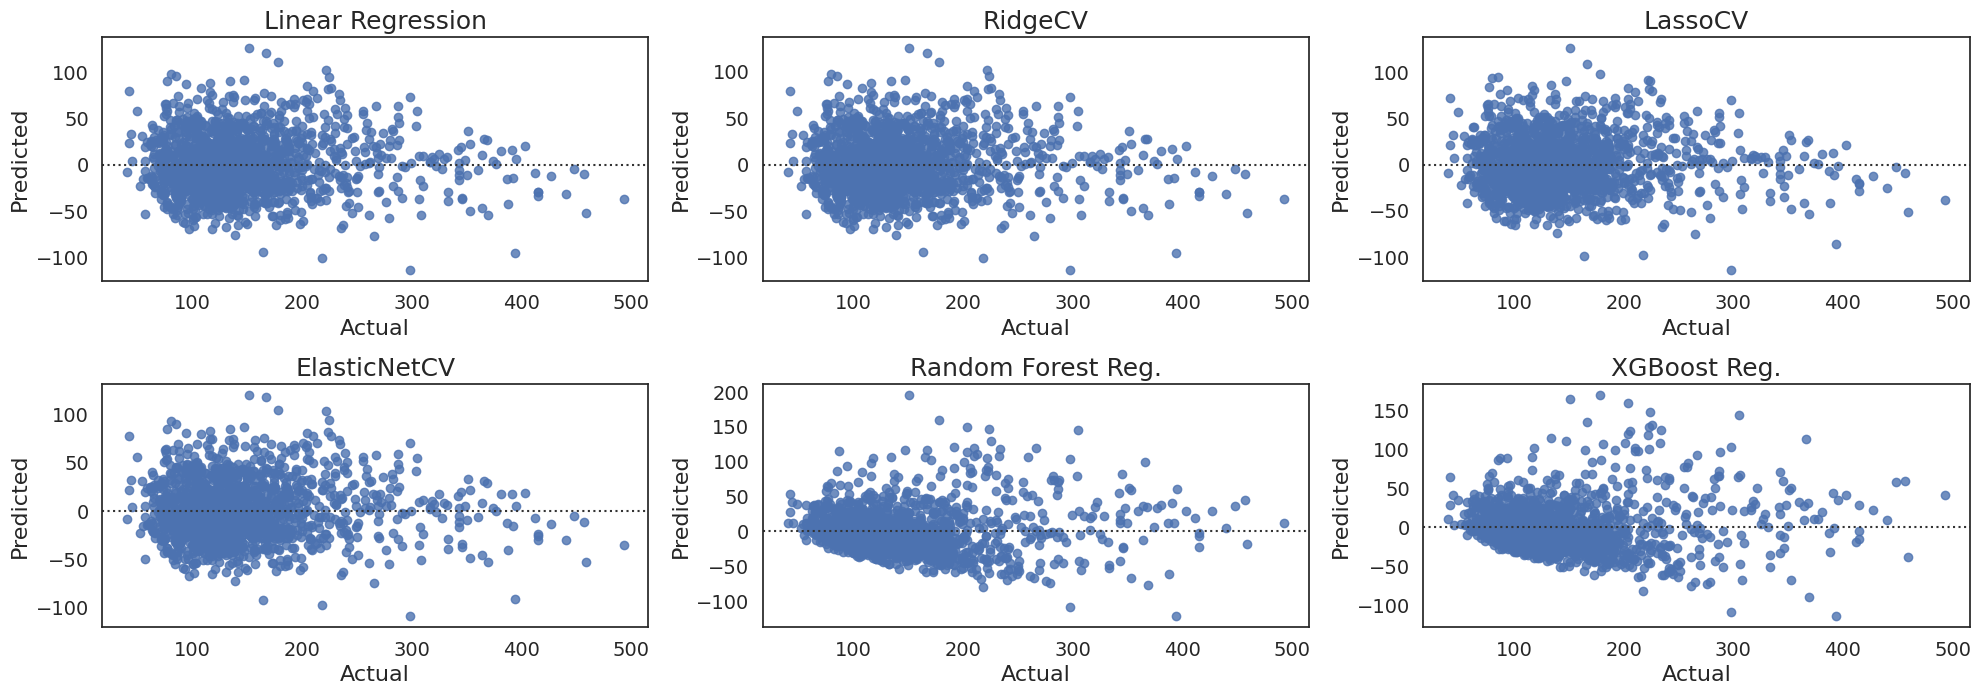

In [ ]:
graphs.residualplots(df      = original_features,
                     columns = ["Linear_Reg.", "RidgeCV",
                                "LassoCV", "ElasticNetCV",
                                "Random Forest Reg.", "XGBoost Reg."],
                     x       = "Actual",
                     dim     = (20,10),
                     titles  = ["Linear Regression", "RidgeCV",
                                "LassoCV", "ElasticNetCV", "Random Forest Reg.",
                                "XGBoost Reg."],
                     row     = 3,
                     col     = 3)

These residual plots reinforce what we saw above: the linear model predictions are tighter whereas the non-linear predictions fan out more with higher values.

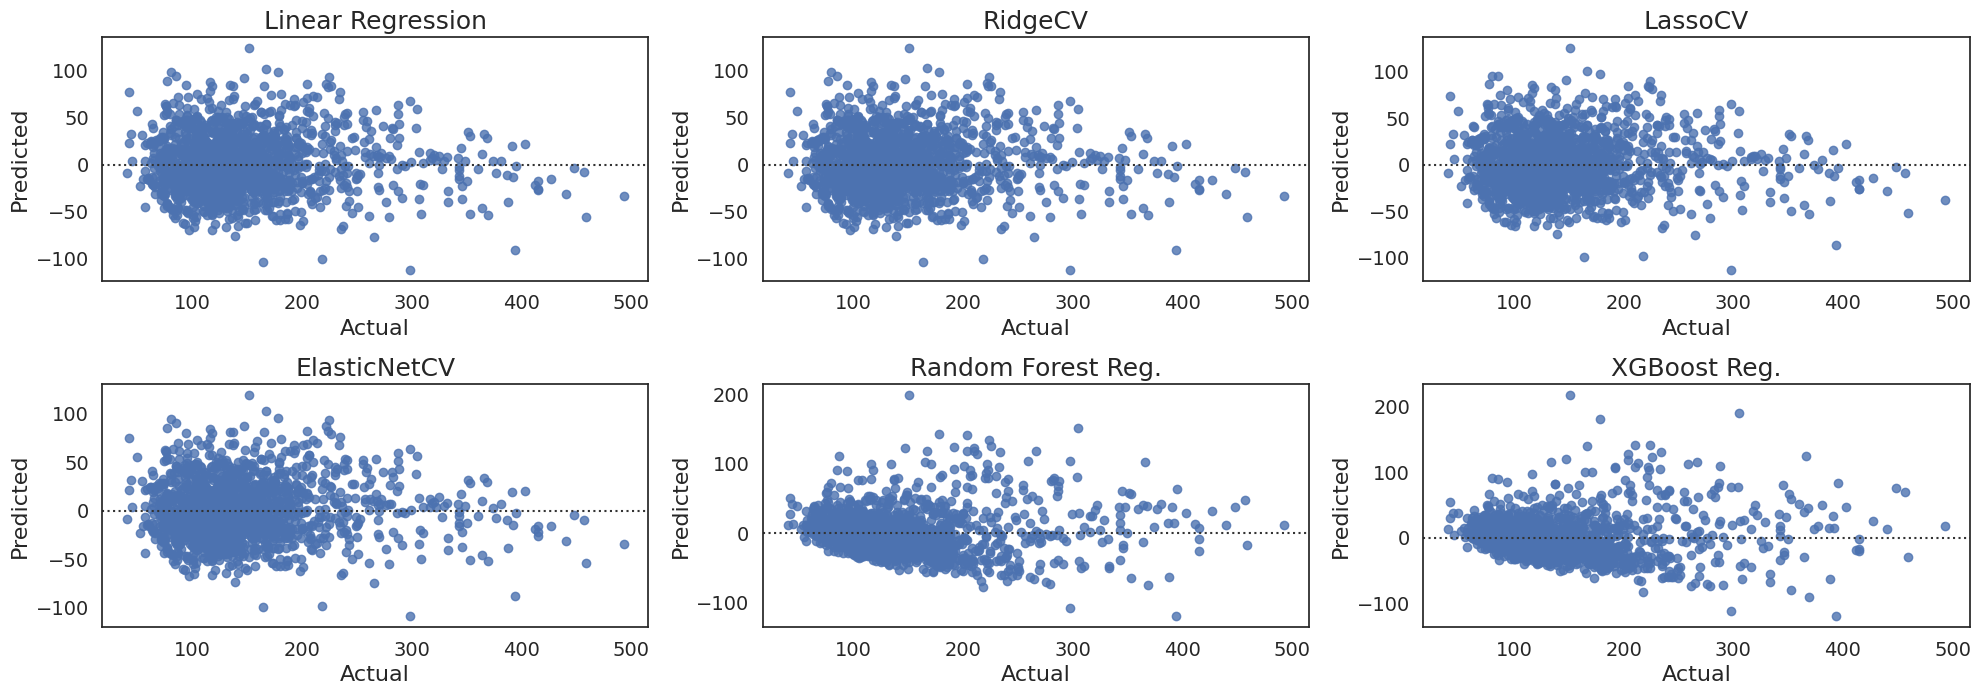

In [ ]:
graphs.residualplots(df      = engineered_features,
                     columns = ["Linear_Reg.", "RidgeCV",
                                "LassoCV", "ElasticNetCV",
                                "Random Forest Reg.", "XGBoost Reg."],
                     x       = "Actual",
                     dim     = (20,10),
                     titles  = ["Linear Regression", "RidgeCV",
                                "LassoCV", "ElasticNetCV", "Random Forest Reg.",
                                "XGBoost Reg."],
                     row     = 3,
                     col     = 3)

Like we saw when we plotted predictions, there's no significant difference between the two versions of predictions.

[Top](#Table-Of-Contents)

### Final Model Choice

Model Performance With The Four Metrics With The Original Features:
    
| Metric                 | Linear Regression | RidgeCV | LassoCV | ElasticNetCV | Random Forest Regression | XGBoost Regression |
|:-----------------------|:-----------------:|:-------:|:-------:|:------------:|:------------------------:|:------------------:|
| **RMSE**               | 44.15             | 44.16   | 44.30   | 44.23        | 41.89                    | 41.56              |
| **MAE**                | 32.46             | 32.46   | 32.50   | 32.40        | 31.01                    | 30.95              |
| **R<sup>2</sup>**      | 0.5131            | 0.5130  | 0.5099  | 0.5099       | 0.5617                   | 0.5686             |
| **Adj. R<sup>2</sup>** | 0.4987            | -----   | -----   | -----        | 0.5488                   | 0.5559             |


Model Performance With The Four Metrics With The Engineered Features:

| Metric                 | Linear Regression | RidgeCV | LassoCV | ElasticNetCV | Random Forest Regression | XGBoost Regression |
|:-----------------------|:-----------------:|:-------:|:-------:|:------------:|:------------------------:|:------------------:|
| **RMSE**               | 44.13             | 44.14   | 44.23   | 44.25        | 41.80                    | 41.90              |
| **MAE**                | 32.49             | 32.48   | 32.50   | 32.43        | 31.98                    | 30.87              |
| **R<sup>2</sup>**      | 0.5136            | 0.5134  | 0.5114  | 0.5110       | 0.5637                   | 0.5615             |
| **Adj. R<sup>2</sup>** | 0.5077            | -----   | -----   | -----        | 0.5585                   | 0.5562             |


Once we had run the all the models, it was a close call between the XGBoost & the random forest as we saw in the original version of our modeling. We chose the XGBoost Regression on the original data set as the best, Random Forest Regression on the engineered data is a close second.  

However, we still need to confirm what if our R<sup>2</sup> value is acceptable a medical setting.

[Top](#Table-Of-Contents)